# Methods to Predict the Existence of Exoplanets

Signal Processing and Time Series Classification of flux (light intensity) data from stars to predict if they have exoplanets

In [1]:
import pandas as pd
import sklearn as sk
import scipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, normalize 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scipy.signal import savgol_filter
from collections import Counter
from imblearn.over_sampling import RandomOverSampler, SMOTE
import math
import timeit
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense
from keras.optimizers import Adam, SGD
from keras import metrics, regularizers
from keras.callbacks import EarlyStopping
from keras import backend as K
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('../Downloads/star_classifier/data/exoTrain.csv')

In [3]:
train.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


In [4]:
test = pd.read_csv('../Downloads/star_classifier/data/exoTest.csv')

In [5]:
test.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,119.88,100.21,86.46,48.68,46.12,39.39,18.57,6.98,6.63,...,14.52,19.29,14.44,-1.62,13.33,45.50,31.93,35.78,269.43,57.72
1,2,5736.59,5699.98,5717.16,5692.73,5663.83,5631.16,5626.39,5569.47,5550.44,...,-581.91,-984.09,-1230.89,-1600.45,-1824.53,-2061.17,-2265.98,-2366.19,-2294.86,-2034.72
2,2,844.48,817.49,770.07,675.01,605.52,499.45,440.77,362.95,207.27,...,17.82,-51.66,-48.29,-59.99,-82.10,-174.54,-95.23,-162.68,-36.79,30.63
3,2,-826.00,-827.31,-846.12,-836.03,-745.50,-784.69,-791.22,-746.50,-709.53,...,122.34,93.03,93.03,68.81,9.81,20.75,20.25,-120.81,-257.56,-215.41
4,2,-39.57,-15.88,-9.16,-6.37,-16.13,-24.05,-0.90,-45.20,-5.04,...,-37.87,-61.85,-27.15,-21.18,-33.76,-85.34,-81.46,-61.98,-69.34,-17.84


# EDA + Data Cleaning

In [6]:
train.shape

(5087, 3198)

In [7]:
test.shape

(570, 3198)

Let's look at the class distribution. Note that 1 represents non-exoplanet stars and 2 represents exoplanet stars

In [8]:
train.LABEL.value_counts()

1    5050
2      37
Name: LABEL, dtype: int64

In [9]:
test.LABEL.value_counts()

1    565
2      5
Name: LABEL, dtype: int64

### Scatter Plot: Non-exoplanet Stars

In [10]:
def plot_scatter(set_type, label, n_samples=15):
    fig = plt.figure(figsize=(15,40))
    x = np.array(range(3197))
    for i in range(n_samples):
        ax = fig.add_subplot(15,5,i+1)
        ax.scatter(x,set_type[set_type.LABEL == label].iloc[i,1:])

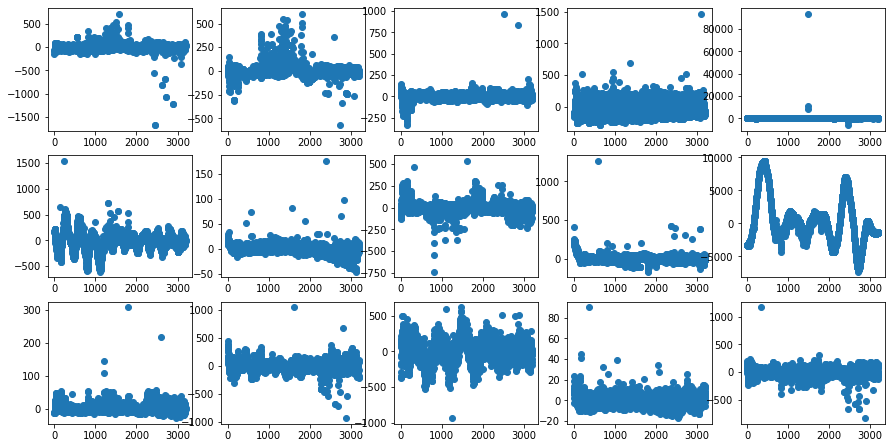

In [11]:
plot_scatter(train,1)

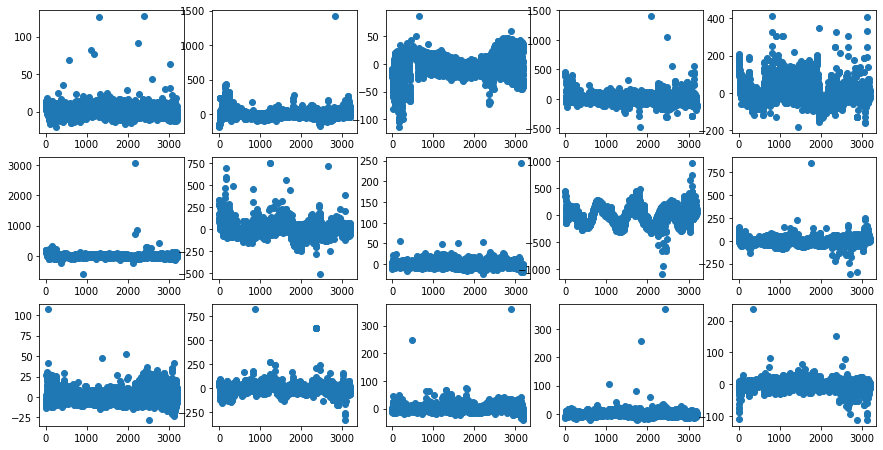

In [12]:
plot_scatter(test,1)

### Scatter Plot: Exoplanet Stars

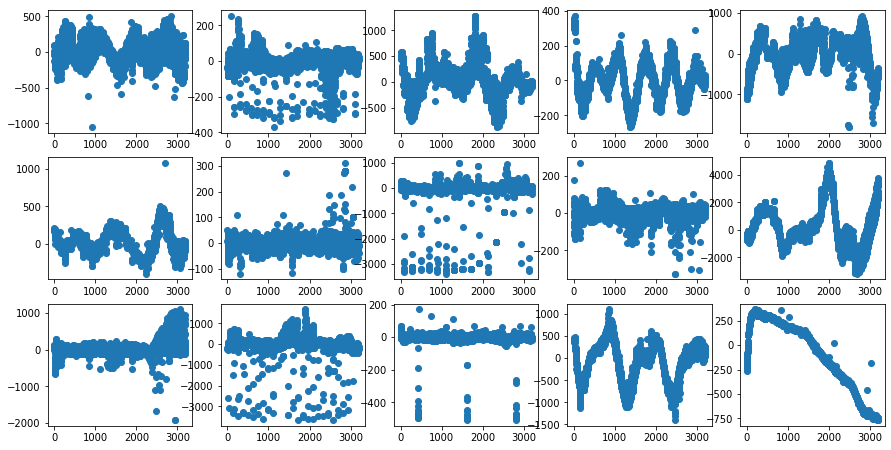

In [13]:
plot_scatter(train,2)

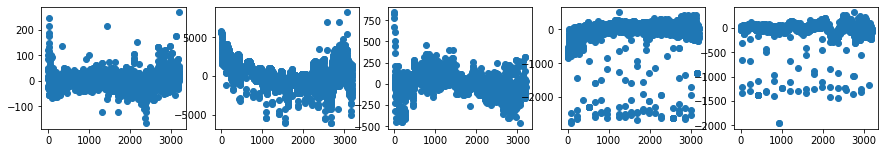

In [14]:
test_exo = len(test[test.LABEL == 2])
plot_scatter(test,2,test_exo)

Some conclusions from visualizing the scatter plots are that non-exoplanet stars don't have a particular trend over time while exoplanet stars have a trend over time that is approximately periodic.

### Histogram: Non-exoplanet Stars

In [15]:
def plot_hist(set_type, label, n_samples=15):
    fig = plt.figure(figsize=(15,40))
    for i in range(n_samples):
        ax = fig.add_subplot(15,5,i+1)
        set_type[set_type.LABEL == label].iloc[i,1:].hist(bins=60)

Let's visualize the flux distribution of the stars

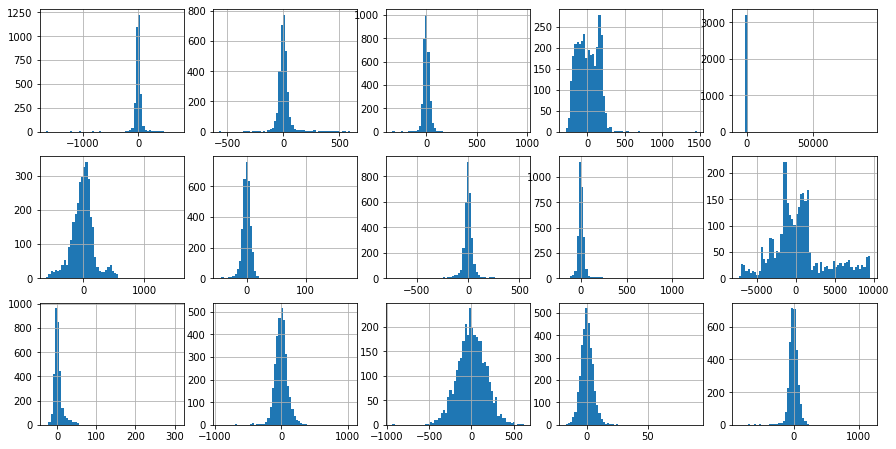

In [16]:
plot_hist(train,1)

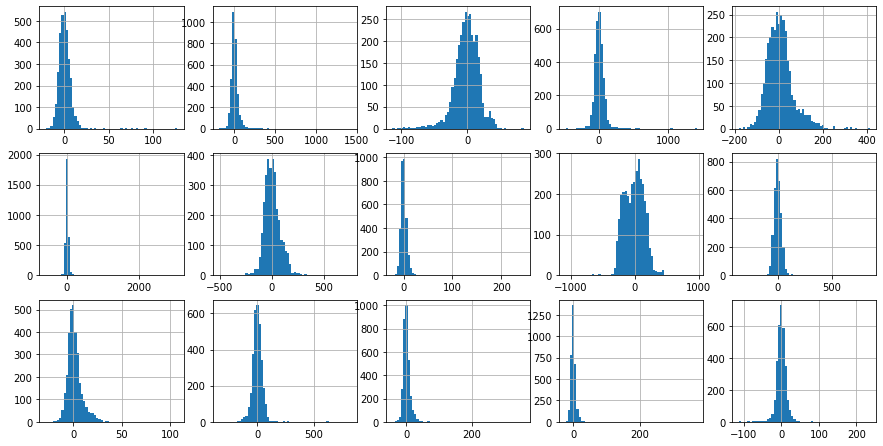

In [17]:
plot_hist(test,1)

### Histogram: Exoplanet Stars

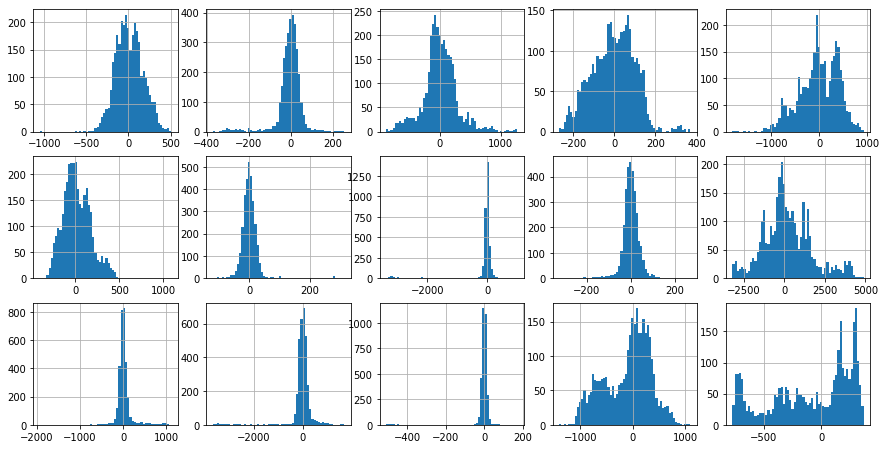

In [18]:
plot_hist(train,2)

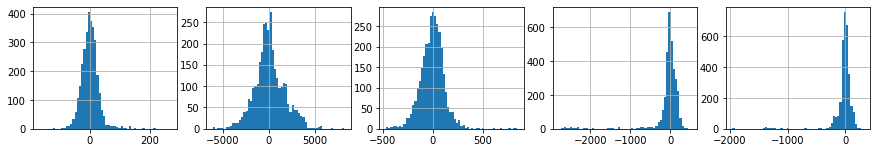

In [19]:
plot_hist(test,2,test_exo)

Some conclusions from visualizing the histograms are that non-exoplanet stars have a narrower distribution because their flux values are more consistent while exoplanet stars have a wider distribution because their flux values vary more

Let's check for any missing values in the dataset

In [20]:
np.where(train.isna().sum() != 0)

(array([], dtype=int64),)

In [21]:
np.where(test.isna().sum() != 0)

(array([], dtype=int64),)

No missing values were found.

### Some observations we can make about the data are that it is highly imbalanced and very noisy.

# Model Building

In [22]:
X_train = train.drop('LABEL', axis=1)
y_train = train['LABEL'].values
X_test = test.drop('LABEL', axis=1)
y_test = test['LABEL'].values

In [23]:
def model_pipeline(X_tr, y_tr, X_ts, y_ts, show_training = False):
    classifiers = [
        {
            'label': 'SVM',
            'model': SVC(), 
        },
        {
            'label': 'KNN',
            'model': KNeighborsClassifier(), 
        },
               {
            'label': 'Decision Tree',
            'model': DecisionTreeClassifier(random_state=4), 
        },
               {
            'label': 'Random Forest',
            'model': RandomForestClassifier(), 
        },
               {
            'label': 'Logistic Regression',
            'model': LogisticRegression(), 
        } 
    ]
        
    for clf in classifiers:
        model = clf['model']
        model.fit(X_tr, y_tr)
          
        if show_training == False:
            preds = model.predict(X_ts)
            print(clf['label'] + ' Classification Report:')
            print()
            print(classification_report(y_ts,preds))
            plot_confusion_matrix(model, X_ts, y_ts, display_labels=['Non-Exoplanet','Exoplanet'])
            plt.grid(False)
            plt.title(clf['label'] + ' Confusion Matrix', fontweight='bold', fontsize=15)
            plt.show()
            print('/////////////////////////////////////////////////////////////////////////////////////////////////')
            print()
            
        else:
            preds_train = model.predict(X_tr)
            print(clf['label'] + ' Classification Report on Training Set:')
            print()
            print(classification_report(y_tr,preds_train))
            plot_confusion_matrix(model, X_tr, y_tr, display_labels=['Non-Exoplanet','Exoplanet'])
            plt.grid(False)
            plt.title(clf['label'] + ' Confusion Matrix', fontweight='bold', fontsize=15)
            plt.show()
            print('/////////////////////////////////////////////////////////////////////////////////////////////////')
            print()

SVM Classification Report:

              precision    recall  f1-score   support

           1       0.99      1.00      1.00       565
           2       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570



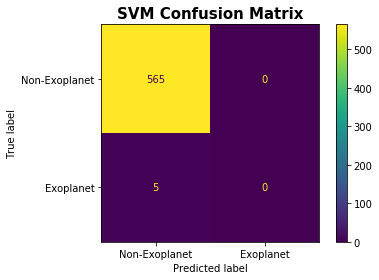

/////////////////////////////////////////////////////////////////////////////////////////////////

KNN Classification Report:

              precision    recall  f1-score   support

           1       0.99      1.00      1.00       565
           2       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570



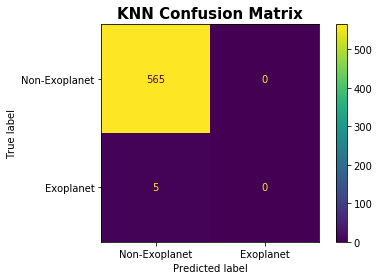

/////////////////////////////////////////////////////////////////////////////////////////////////

Decision Tree Classification Report:

              precision    recall  f1-score   support

           1       0.99      0.99      0.99       565
           2       0.25      0.40      0.31         5

    accuracy                           0.98       570
   macro avg       0.62      0.69      0.65       570
weighted avg       0.99      0.98      0.99       570



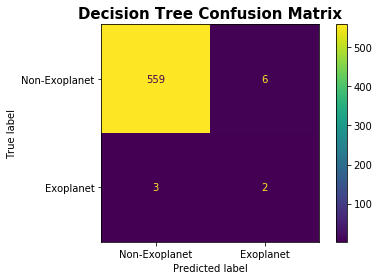

/////////////////////////////////////////////////////////////////////////////////////////////////

Random Forest Classification Report:

              precision    recall  f1-score   support

           1       0.99      1.00      1.00       565
           2       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570



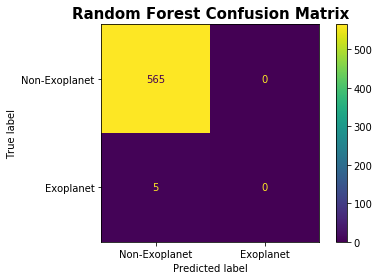

/////////////////////////////////////////////////////////////////////////////////////////////////

Logistic Regression Classification Report:

              precision    recall  f1-score   support

           1       0.99      0.53      0.69       565
           2       0.01      0.60      0.02         5

    accuracy                           0.53       570
   macro avg       0.50      0.57      0.36       570
weighted avg       0.98      0.53      0.69       570



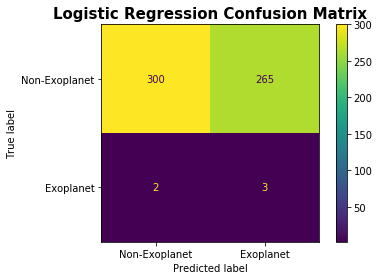

/////////////////////////////////////////////////////////////////////////////////////////////////



In [24]:
model_pipeline(X_train, y_train, X_test, y_test)

# Oversampling/Undersampling

Let's handle the imbalanced data using SMOTE

In [25]:
oversample = SMOTE()
X_resampled, y_resampled = oversample.fit_resample(X_train, y_train)

In [26]:
counter1 = Counter(y_train)
counter2 = Counter(y_resampled)
print(counter1)
print(counter2)

Counter({1: 5050, 2: 37})
Counter({2: 5050, 1: 5050})


In [27]:
print(X_resampled.shape)
print(y_resampled.shape)

(10100, 3197)
(10100,)


SVM Classification Report:

              precision    recall  f1-score   support

           1       0.99      1.00      0.99       565
           2       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570



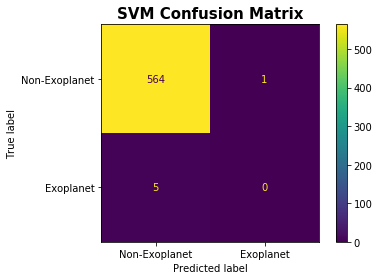

/////////////////////////////////////////////////////////////////////////////////////////////////

KNN Classification Report:

              precision    recall  f1-score   support

           1       0.99      0.99      0.99       565
           2       0.14      0.20      0.17         5

    accuracy                           0.98       570
   macro avg       0.57      0.59      0.58       570
weighted avg       0.99      0.98      0.98       570



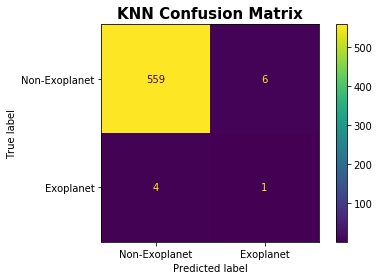

/////////////////////////////////////////////////////////////////////////////////////////////////

Decision Tree Classification Report:

              precision    recall  f1-score   support

           1       0.99      0.98      0.99       565
           2       0.08      0.20      0.12         5

    accuracy                           0.97       570
   macro avg       0.54      0.59      0.55       570
weighted avg       0.98      0.97      0.98       570



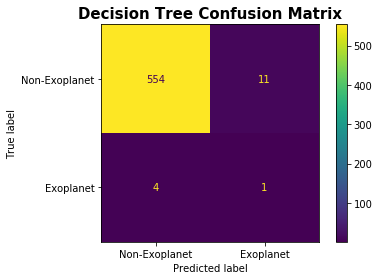

/////////////////////////////////////////////////////////////////////////////////////////////////

Random Forest Classification Report:

              precision    recall  f1-score   support

           1       0.99      1.00      1.00       565
           2       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570



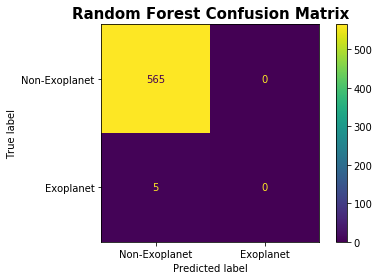

/////////////////////////////////////////////////////////////////////////////////////////////////

Logistic Regression Classification Report:

              precision    recall  f1-score   support

           1       0.99      0.58      0.73       565
           2       0.01      0.60      0.02         5

    accuracy                           0.58       570
   macro avg       0.50      0.59      0.38       570
weighted avg       0.99      0.58      0.72       570



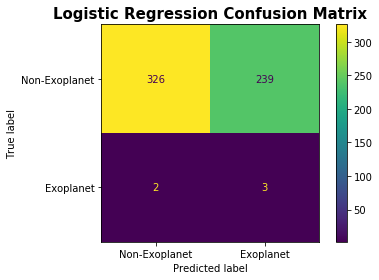

/////////////////////////////////////////////////////////////////////////////////////////////////



In [28]:
model_pipeline(X_resampled, y_resampled, X_test, y_test)

Applying SMOTE to the training data doesn't seem to improve the performance of the classifier and is too computationally expensive. So, we will use the original training data and not the resampled training data moving forward.

# Signal Processing

## Fast-Fourier Transform

In [29]:
def apply_fft(X_tr,X_ts):
    tr_fft = np.abs(np.fft.fft(X_tr, axis=1))
    ts_fft = np.abs(np.fft.fft(X_ts, axis=1))
    return tr_fft,ts_fft

In [30]:
train_fft, test_fft = apply_fft(X_train,X_test)

In [31]:
train_fft

array([[ 31822.48      ,   3542.69725989,  55671.61280692, ...,
         52952.70195631,  55671.61280692,   3542.69725989],
       [ 23747.1       ,  18904.03483095,  23034.01375377, ...,
         23943.70167127,  23034.01375377,  18904.03483095],
       [ 26180.51      , 143610.48759074,  41912.29468855, ...,
        365999.61678651,  41912.29468855, 143610.48759074],
       ...,
       [  9398.42000001,   5514.03371502,  18216.47890902, ...,
          7032.65269996,  18216.47890902,   5514.03371502],
       [  2567.54      ,   1986.45522747,   2780.97513937, ...,
          3810.82651497,   2780.97513937,   1986.45522747],
       [ 16608.95000001,  12716.78586068,  20542.92617575, ...,
          8212.03658663,  20542.92617575,  12716.78586068]])

In [32]:
train_fft_plot = pd.DataFrame(train_fft)
test_fft_plot = pd.DataFrame(test_fft)

In [33]:
train_fft_plot.head()

,0,1,2,3,4,5,6,7,8,9,...,3187,3188,3189,3190,3191,3192,3193,3194,3195,3196
0,31822.48,3542.697260,55671.612807,52952.701956,200751.502826,29353.124433,25093.521120,16709.544467,28812.723753,25559.772897,...,2992.545812,25559.772897,28812.723753,16709.544467,25093.521120,29353.124433,200751.502826,52952.701956,55671.612807,3542.697260
1,23747.10,18904.034831,23034.013754,23943.701671,13819.563577,20765.092016,17303.647198,7401.036438,8735.502062,8872.865012,...,7383.345790,8872.865012,8735.502062,7401.036438,17303.647198,20765.092016,13819.563577,23943.701671,23034.013754,18904.034831
2,26180.51,143610.487591,41912.294689,365999.616787,104066.520704,189543.713858,123398.774919,83153.412884,22577.194163,99916.175640,...,48754.521520,99916.175640,22577.194163,83153.412884,123398.774919,189543.713858,104066.520704,365999.616787,41912.294689,143610.487591
3,14855.14,12371.439885,33309.457851,69042.125217,64290.918441,172076.407434,49458.284691,45511.563319,35061.742616,21291.359595,...,17060.829321,21291.359595,35061.742616,45511.563319,49458.284691,172076.407434,64290.918441,69042.125217,33309.457851,12371.439885
4,45527.39,310414.084694,140433.251401,400661.916141,406211.307176,283810.829694,319055.791578,79144.154130,99624.063739,189609.298602,...,13455.026552,189609.298602,99624.063739,79144.154130,319055.791578,283810.829694,406211.307176,400661.916141,140433.251401,310414.084694


In [34]:
train.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


In [35]:
train_fft_plot['LABEL'] = train['LABEL']
cols = list(train_fft_plot.columns)
cols = [cols[-1]] + cols[:-1]
train_fft_plot = train_fft_plot[cols]
train_fft_plot.head()

,LABEL,0,1,2,3,4,5,6,7,8,...,3187,3188,3189,3190,3191,3192,3193,3194,3195,3196
0,2,31822.48,3542.697260,55671.612807,52952.701956,200751.502826,29353.124433,25093.521120,16709.544467,28812.723753,...,2992.545812,25559.772897,28812.723753,16709.544467,25093.521120,29353.124433,200751.502826,52952.701956,55671.612807,3542.697260
1,2,23747.10,18904.034831,23034.013754,23943.701671,13819.563577,20765.092016,17303.647198,7401.036438,8735.502062,...,7383.345790,8872.865012,8735.502062,7401.036438,17303.647198,20765.092016,13819.563577,23943.701671,23034.013754,18904.034831
2,2,26180.51,143610.487591,41912.294689,365999.616787,104066.520704,189543.713858,123398.774919,83153.412884,22577.194163,...,48754.521520,99916.175640,22577.194163,83153.412884,123398.774919,189543.713858,104066.520704,365999.616787,41912.294689,143610.487591
3,2,14855.14,12371.439885,33309.457851,69042.125217,64290.918441,172076.407434,49458.284691,45511.563319,35061.742616,...,17060.829321,21291.359595,35061.742616,45511.563319,49458.284691,172076.407434,64290.918441,69042.125217,33309.457851,12371.439885
4,2,45527.39,310414.084694,140433.251401,400661.916141,406211.307176,283810.829694,319055.791578,79144.154130,99624.063739,...,13455.026552,189609.298602,99624.063739,79144.154130,319055.791578,283810.829694,406211.307176,400661.916141,140433.251401,310414.084694


In [36]:
test_fft_plot['LABEL'] = test['LABEL']
cols = list(test_fft_plot.columns)
cols = [cols[-1]] + cols[:-1]
test_fft_plot = test_fft_plot[cols]
test_fft_plot.head()

,LABEL,0,1,2,3,4,5,6,7,8,...,3187,3188,3189,3190,3191,3192,3193,3194,3195,3196
0,2,2336.44,1.010599e+04,17673.365899,7843.480229,6003.294139,7233.286852,7642.207632,3528.158697,3507.134893,...,3478.849855,4162.501513,3507.134893,3528.158697,7642.207632,7233.286852,6003.294139,7843.480229,17673.365899,1.010599e+04
1,2,305036.52,1.941835e+06,611030.236658,401110.349063,253011.570670,230486.625738,901922.049009,386620.591840,382749.490065,...,141502.465300,425318.824620,382749.490065,386620.591840,901922.049009,230486.625738,253011.570670,401110.349063,611030.236658,1.941835e+06
2,2,19294.33,1.333539e+05,34843.973448,15267.356940,15379.377836,60563.004643,31069.829077,29142.625941,18886.810358,...,10159.742301,4302.154612,18886.810358,29142.625941,31069.829077,60563.004643,15379.377836,15267.356940,34843.973448,1.333539e+05
3,2,198318.67,1.224174e+05,67392.748075,16762.498635,53518.455670,66570.114293,62249.247191,19723.361376,28755.653151,...,54697.382090,20904.330935,28755.653151,19723.361376,62249.247191,66570.114293,53518.455670,16762.498635,67392.748075,1.224174e+05
4,2,75670.79,1.622826e+04,27147.827152,29117.750443,63294.075858,90211.529159,40888.462531,68733.049795,33646.127913,...,11747.406494,19327.208402,33646.127913,68733.049795,40888.462531,90211.529159,63294.075858,29117.750443,27147.827152,1.622826e+04


Let's visualize the time-domain flux (original) and the frequency-domain flux (after applying fft) for non-exoplanet and exoplanet stars

### Visualizing Time-domain Signal: Non-exoplanet Stars

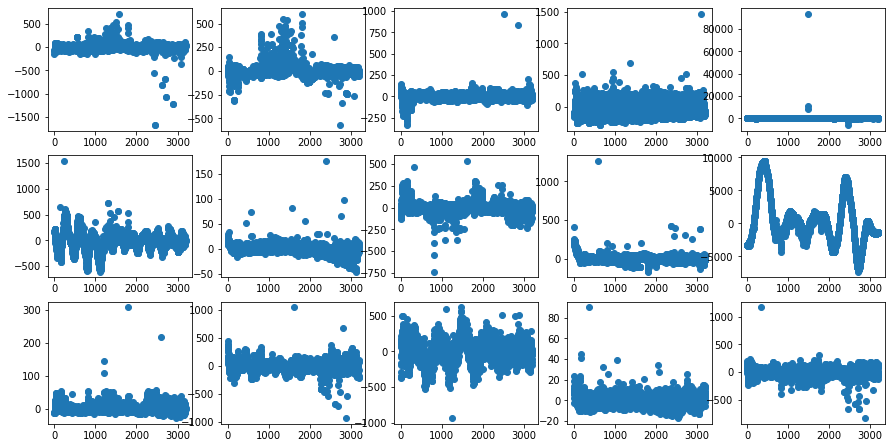

In [37]:
plot_scatter(train,1)

### Visualizing Frequency-domain Signal: Non-exoplanet Stars

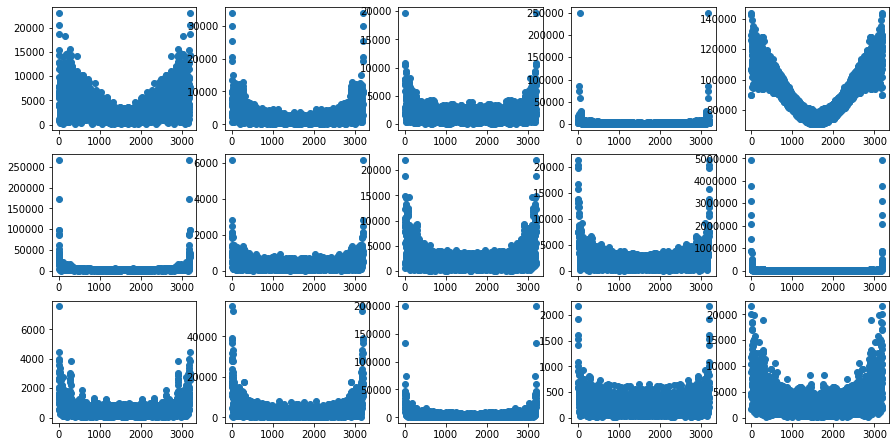

In [38]:
plot_scatter(train_fft_plot,1)

### Visualizing Time-domain Signal: Exoplanet Stars

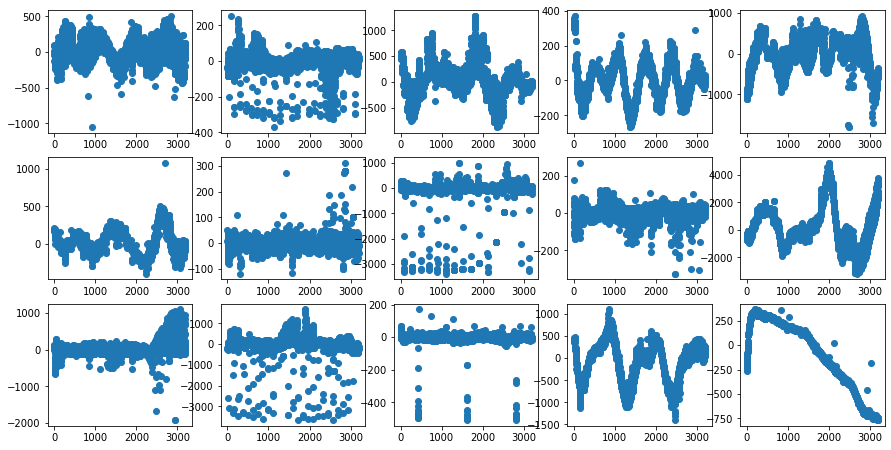

In [39]:
plot_scatter(train,2)

### Visualizing Frequency-domain Signal: Exoplanet Stars

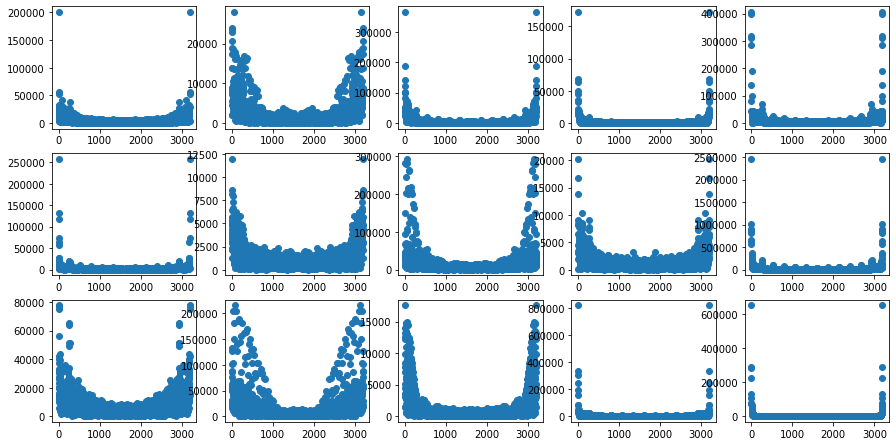

In [40]:
plot_scatter(train_fft_plot,2)

## Noise Reduction

In [41]:
def plot_preprocessing(tr,ts):
    tr = pd.DataFrame(tr)
    ts = pd.DataFrame(ts)
    
    tr['LABEL'] = train['LABEL']
    cols = list(tr.columns)
    cols = [cols[-1]] + cols[:-1]
    tr = tr[cols]

    ts['LABEL'] = test['LABEL']
    cols = list(ts.columns)
    cols = [cols[-1]] + cols[:-1]
    ts = ts[cols]
    
    return tr,ts

In [42]:
def apply_filter(tr_fft,ts_fft,window_length,polyorder):
    tr_sav = savgol_filter(tr_fft,window_length=window_length,polyorder=polyorder)
    ts_sav = savgol_filter(ts_fft,window_length=window_length,polyorder=polyorder)
    return tr_sav,ts_sav

In [43]:
train_sav, test_sav = apply_filter(train_fft,test_fft,21,4)

In [44]:
train_sav_plot, test_sav_plot = plot_preprocessing(train_sav,test_sav)

### Visualizing Filtered Signal: Non-exoplanet Stars

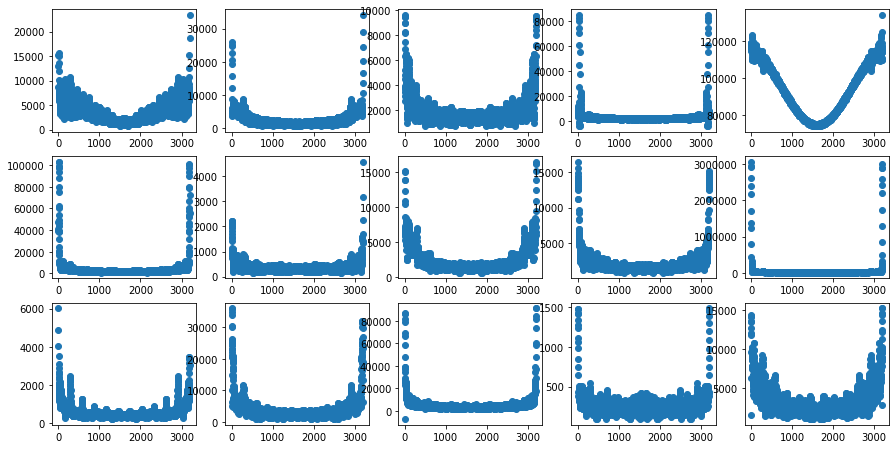

In [45]:
plot_scatter(train_sav_plot,1)

### Visualizing Filtered Signal: Exoplanet Stars

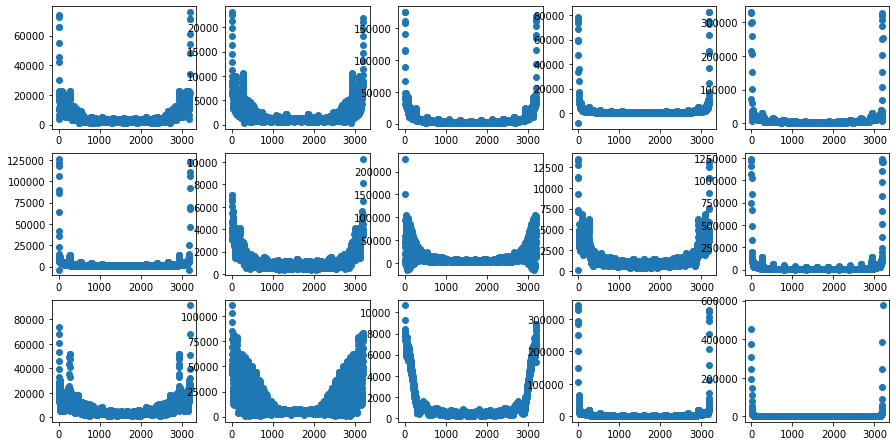

In [46]:
plot_scatter(train_sav_plot,2)

SVM Classification Report:

              precision    recall  f1-score   support

           1       0.99      1.00      1.00       565
           2       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570



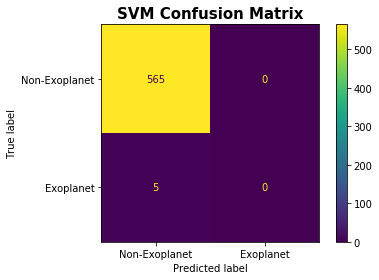

/////////////////////////////////////////////////////////////////////////////////////////////////

KNN Classification Report:

              precision    recall  f1-score   support

           1       0.99      1.00      1.00       565
           2       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570



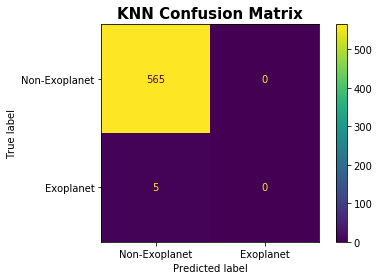

/////////////////////////////////////////////////////////////////////////////////////////////////

Decision Tree Classification Report:

              precision    recall  f1-score   support

           1       0.99      0.99      0.99       565
           2       0.17      0.20      0.18         5

    accuracy                           0.98       570
   macro avg       0.58      0.60      0.59       570
weighted avg       0.99      0.98      0.98       570



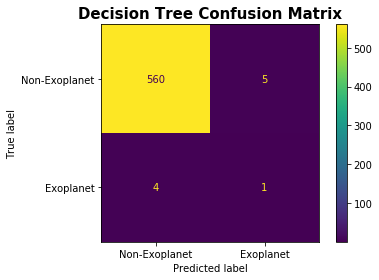

/////////////////////////////////////////////////////////////////////////////////////////////////

Random Forest Classification Report:

              precision    recall  f1-score   support

           1       0.99      1.00      1.00       565
           2       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570



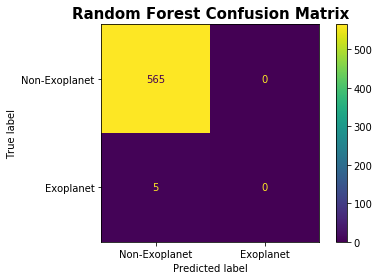

/////////////////////////////////////////////////////////////////////////////////////////////////

Logistic Regression Classification Report:

              precision    recall  f1-score   support

           1       0.99      0.99      0.99       565
           2       0.25      0.20      0.22         5

    accuracy                           0.99       570
   macro avg       0.62      0.60      0.61       570
weighted avg       0.99      0.99      0.99       570



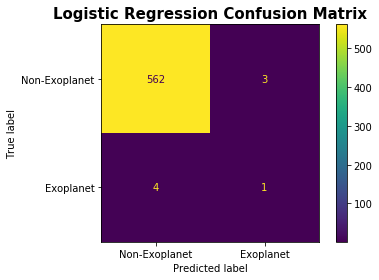

/////////////////////////////////////////////////////////////////////////////////////////////////



In [47]:
model_pipeline(train_sav, y_train, test_sav, y_test)

# Feature Engineering

## Normalization

In [48]:
def apply_norm(tr_sav,ts_sav):
    tr_norm = normalize(tr_sav)
    ts_norm = normalize(ts_sav)
    return tr_norm,ts_norm

In [49]:
train_norm, test_norm = apply_norm(train_sav,test_sav)

In [50]:
train_norm_plot, test_norm_plot = plot_preprocessing(train_norm,test_norm)

### Visualizing Normalized Signal: Non-exoplanet Stars

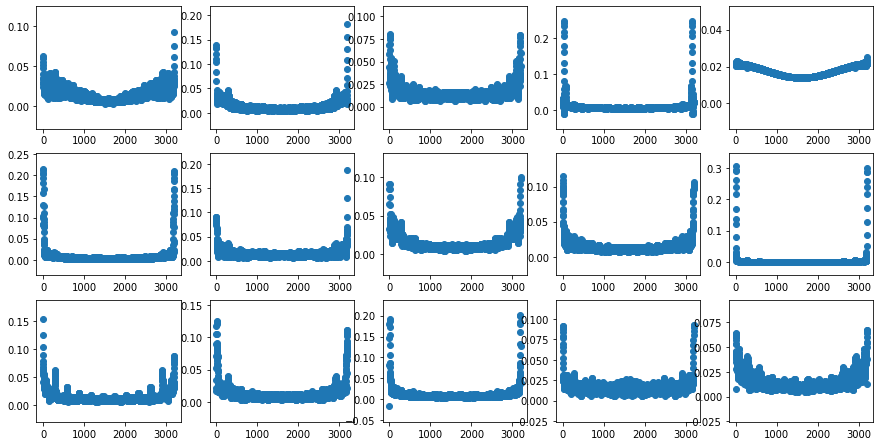

In [51]:
plot_scatter(train_norm_plot,1)

### Visualizing Normalized Signal: Exoplanet Stars

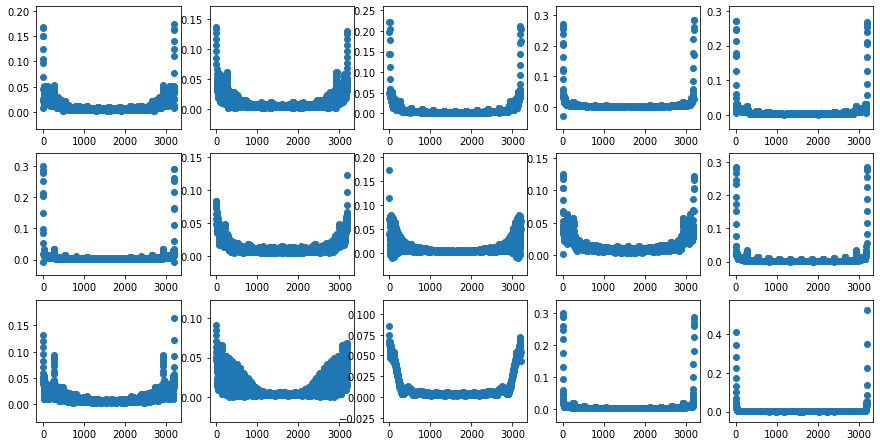

In [52]:
plot_scatter(train_norm_plot,2)

SVM Classification Report:

              precision    recall  f1-score   support

           1       0.99      1.00      1.00       565
           2       1.00      0.20      0.33         5

    accuracy                           0.99       570
   macro avg       1.00      0.60      0.66       570
weighted avg       0.99      0.99      0.99       570



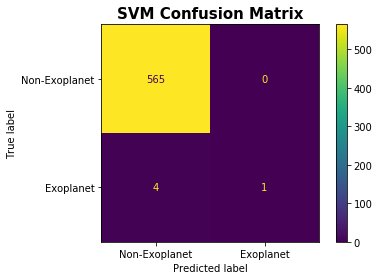

/////////////////////////////////////////////////////////////////////////////////////////////////

KNN Classification Report:

              precision    recall  f1-score   support

           1       0.99      1.00      1.00       565
           2       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570



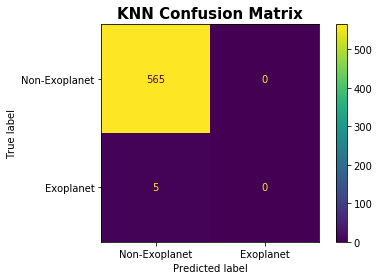

/////////////////////////////////////////////////////////////////////////////////////////////////

Decision Tree Classification Report:

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       565
           2       1.00      1.00      1.00         5

    accuracy                           1.00       570
   macro avg       1.00      1.00      1.00       570
weighted avg       1.00      1.00      1.00       570



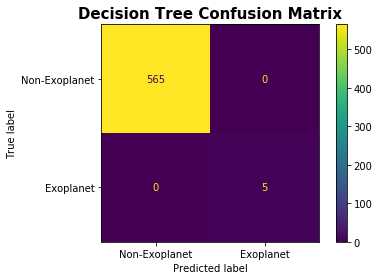

/////////////////////////////////////////////////////////////////////////////////////////////////

Random Forest Classification Report:

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       565
           2       1.00      0.60      0.75         5

    accuracy                           1.00       570
   macro avg       1.00      0.80      0.87       570
weighted avg       1.00      1.00      1.00       570



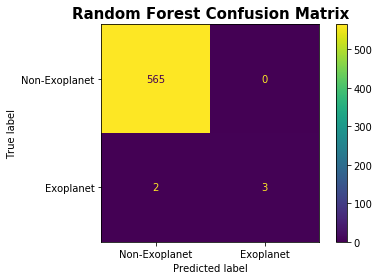

/////////////////////////////////////////////////////////////////////////////////////////////////

Logistic Regression Classification Report:

              precision    recall  f1-score   support

           1       0.99      1.00      1.00       565
           2       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570



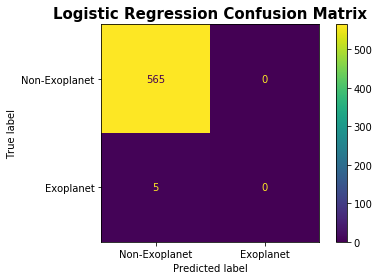

/////////////////////////////////////////////////////////////////////////////////////////////////



In [53]:
model_pipeline(train_norm, y_train, test_norm, y_test)

## Standardization

In [54]:
def apply_stand(tr_norm,ts_norm):
    scaler = RobustScaler()
    tr_scaled = scaler.fit_transform(tr_norm)
    ts_scaled = scaler.transform(ts_norm)
    return tr_scaled,ts_scaled

In [55]:
train_scaled, test_scaled = apply_stand(train_norm,test_norm)

In [56]:
train_scaled_plot, test_scaled_plot = plot_preprocessing(train_scaled,test_scaled)

### Visualizing Standardized Signal: Non-exoplanet Stars

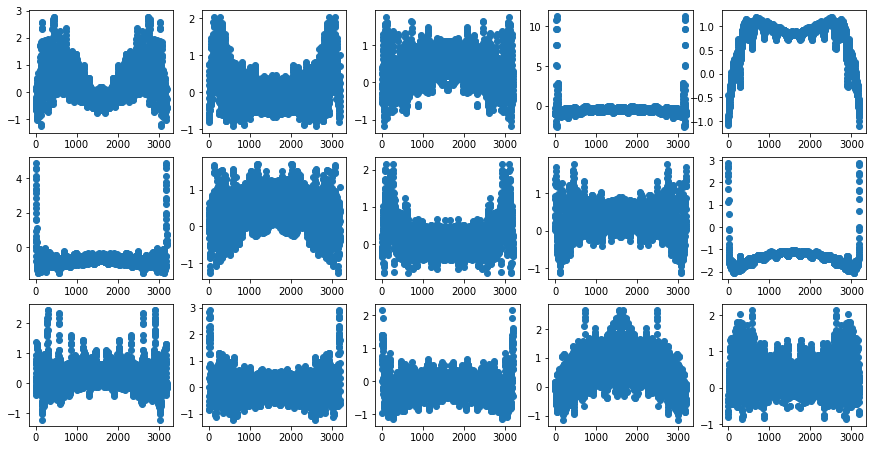

In [57]:
plot_scatter(train_scaled_plot,1)

### Visualizing Standardized Signal: Exoplanet Stars

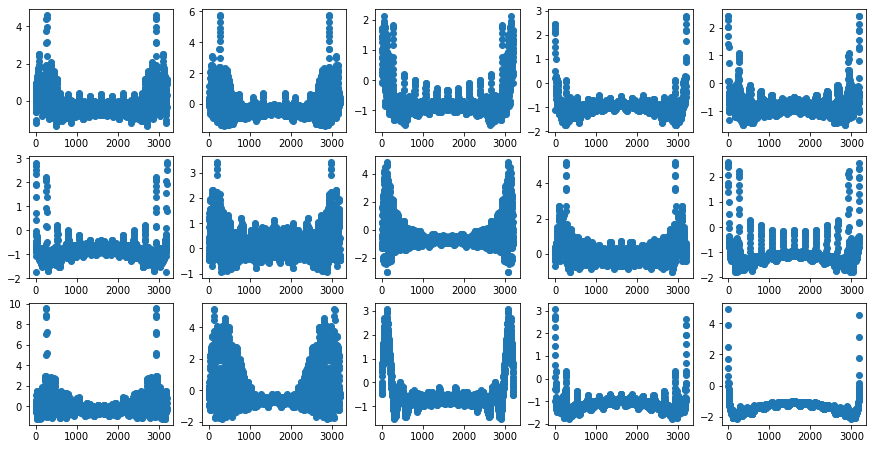

In [58]:
plot_scatter(train_scaled_plot,2)

SVM Classification Report:

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       565
           2       1.00      0.60      0.75         5

    accuracy                           1.00       570
   macro avg       1.00      0.80      0.87       570
weighted avg       1.00      1.00      1.00       570



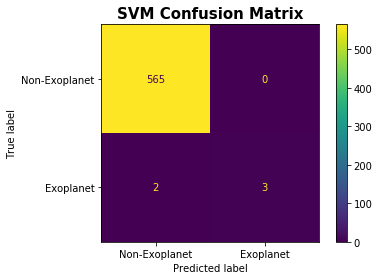

/////////////////////////////////////////////////////////////////////////////////////////////////

KNN Classification Report:

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       565
           2       1.00      0.60      0.75         5

    accuracy                           1.00       570
   macro avg       1.00      0.80      0.87       570
weighted avg       1.00      1.00      1.00       570



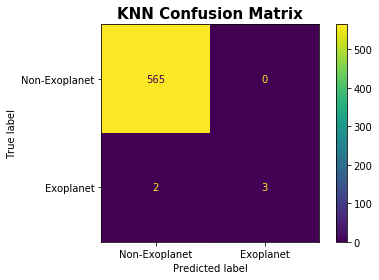

/////////////////////////////////////////////////////////////////////////////////////////////////

Decision Tree Classification Report:

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       565
           2       1.00      1.00      1.00         5

    accuracy                           1.00       570
   macro avg       1.00      1.00      1.00       570
weighted avg       1.00      1.00      1.00       570



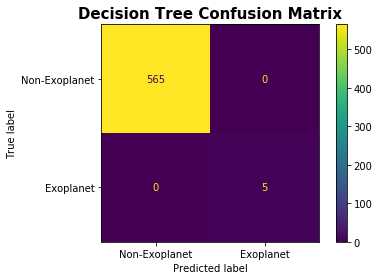

/////////////////////////////////////////////////////////////////////////////////////////////////

Random Forest Classification Report:

              precision    recall  f1-score   support

           1       0.99      1.00      1.00       565
           2       1.00      0.20      0.33         5

    accuracy                           0.99       570
   macro avg       1.00      0.60      0.66       570
weighted avg       0.99      0.99      0.99       570



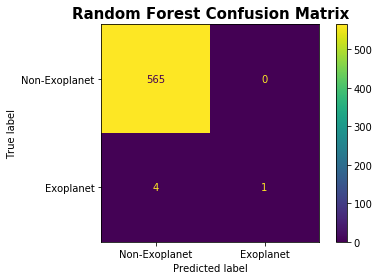

/////////////////////////////////////////////////////////////////////////////////////////////////

Logistic Regression Classification Report:

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       565
           2       0.60      0.60      0.60         5

    accuracy                           0.99       570
   macro avg       0.80      0.80      0.80       570
weighted avg       0.99      0.99      0.99       570



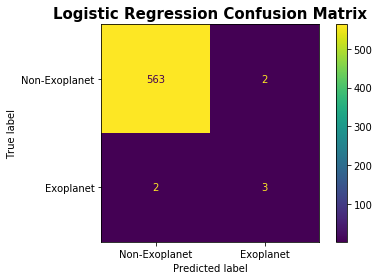

/////////////////////////////////////////////////////////////////////////////////////////////////



In [59]:
model_pipeline(train_scaled, y_train, test_scaled, y_test)

We get very good results on the test set after performing signal processing and feature engineering. Let's evaluate the models on the training set now to check for overfitting

SVM Classification Report on Training Set:

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      5050
           2       1.00      0.49      0.65        37

    accuracy                           1.00      5087
   macro avg       1.00      0.74      0.83      5087
weighted avg       1.00      1.00      1.00      5087



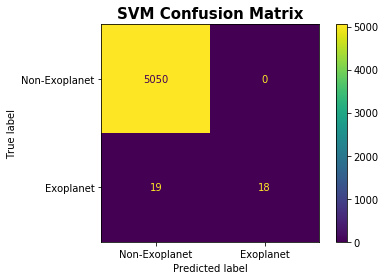

/////////////////////////////////////////////////////////////////////////////////////////////////

KNN Classification Report on Training Set:

              precision    recall  f1-score   support

           1       0.99      1.00      1.00      5050
           2       1.00      0.27      0.43        37

    accuracy                           0.99      5087
   macro avg       1.00      0.64      0.71      5087
weighted avg       0.99      0.99      0.99      5087



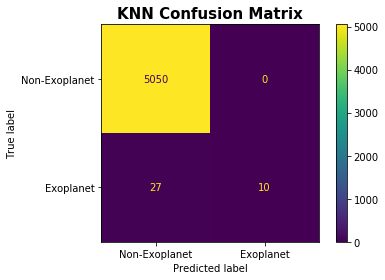

/////////////////////////////////////////////////////////////////////////////////////////////////

Decision Tree Classification Report on Training Set:

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      5050
           2       1.00      1.00      1.00        37

    accuracy                           1.00      5087
   macro avg       1.00      1.00      1.00      5087
weighted avg       1.00      1.00      1.00      5087



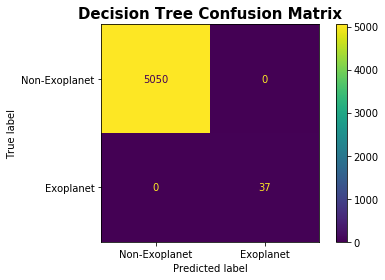

/////////////////////////////////////////////////////////////////////////////////////////////////

Random Forest Classification Report on Training Set:

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      5050
           2       1.00      1.00      1.00        37

    accuracy                           1.00      5087
   macro avg       1.00      1.00      1.00      5087
weighted avg       1.00      1.00      1.00      5087



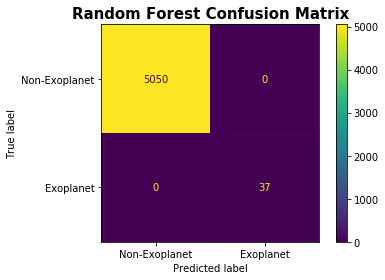

/////////////////////////////////////////////////////////////////////////////////////////////////

Logistic Regression Classification Report on Training Set:

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      5050
           2       1.00      0.95      0.97        37

    accuracy                           1.00      5087
   macro avg       1.00      0.97      0.99      5087
weighted avg       1.00      1.00      1.00      5087



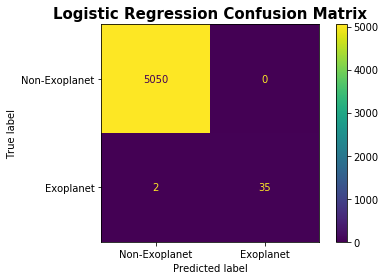

/////////////////////////////////////////////////////////////////////////////////////////////////



In [60]:
model_pipeline(train_scaled, y_train, test_scaled, y_test, True)

We get 100% precision and 100% recall on the test set and training set using Decision Tree Classifier. Thus, our best classifier is not overfitting.

# Neural Networks

### Let's create a shallow neural network using TensorFlow without any data processing

In [61]:
X_train_nn = np.expand_dims(X_train, axis=2)
X_test_nn = np.expand_dims(X_test, axis=2)

y_train_nn = np.zeros((y_train.shape[0], 2))
y_train_nn[np.arange(y_train.size), y_train-1] = 1
y_test_nn = np.zeros((y_test.shape[0], 2))
y_test_nn[np.arange(y_test.size), y_test-1] = 1

In [62]:
print(X_train_nn.shape)
print(y_train_nn.shape)
print(X_test_nn.shape)
print(y_test_nn.shape)

(5087, 3197, 1)
(5087, 2)
(570, 3197, 1)
(570, 2)


In [63]:
EPOCHS = 20
VAL_SPLIT = 0.1
BATCH_SIZE = 120
num_classes = 2
learn_rate = 0.001
early_stop = EarlyStopping(monitor=['val_loss', 'accuracy','val_accuracy'])

In [64]:
def create_nn(X_tr):
    model = Sequential()
    input_shape=(X_tr.shape[1], 1)
    model.add(Conv1D(filters = 32, input_shape = input_shape, kernel_size=(3), activation = 'relu', 
                     kernel_regularizer='l2', padding='same'))
    model.add(MaxPooling1D(pool_size = 2, strides = 2))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(64, activation = 'relu', kernel_regularizer='l2'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation = "sigmoid", kernel_regularizer='l2'))
    
    model.compile(optimizer=Adam(lr=learn_rate), loss='binary_crossentropy')
    
    model.summary()

    return model

In [65]:
model_nn = create_nn(X_train_nn)
start_time_train = timeit.default_timer()
training_history = model_nn.fit(X_train_nn, y_train_nn, validation_split = VAL_SPLIT, 
                            epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True)
time_elapsed = timeit.default_timer() - start_time_train
print('Training time: ' + str(time_elapsed))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 3197, 32)          128       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1598, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 1598, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 51136)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                3272768   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1

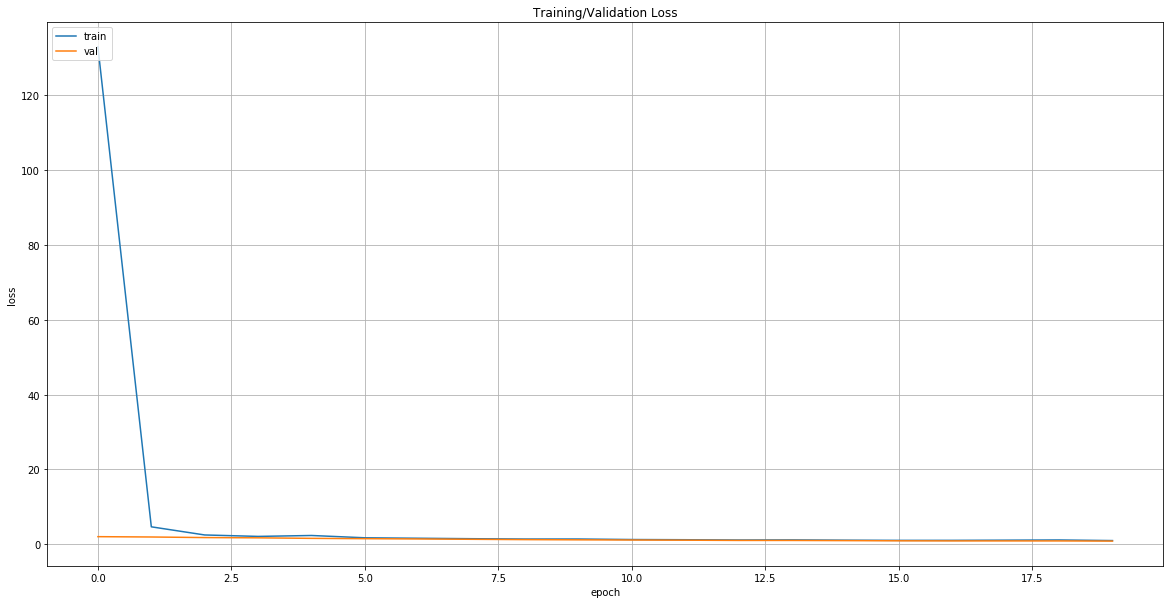

In [66]:
plt.figure(figsize = (20,10))
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('Training/Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()

In [67]:
preds_train = model_nn.predict(X_train_nn)

In [68]:
preds_train.shape

(5087, 2)

In [69]:
preds_train = np.argmax(preds_train, axis=1)
preds_train.shape

(5087,)

In [70]:
y_train_max = np.argmax(y_train_nn, axis =1)

In [71]:
y_train_max.shape

(5087,)

In [72]:
def classification_summary(predictions,true):
    print(classification_report(true,predictions))
    fig, ax = plt.subplots(figsize=(8,6))
    cm = confusion_matrix(true, predictions)
    sns.heatmap(cm, annot=True)
    ax.set_ylim([2,0])
    plt.title('Confusion Matrix', fontweight='bold', fontsize=15)
    plt.show()

Classification Report on Training Set:

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5050
           1       0.00      0.00      0.00        37

    accuracy                           0.99      5087
   macro avg       0.50      0.50      0.50      5087
weighted avg       0.99      0.99      0.99      5087



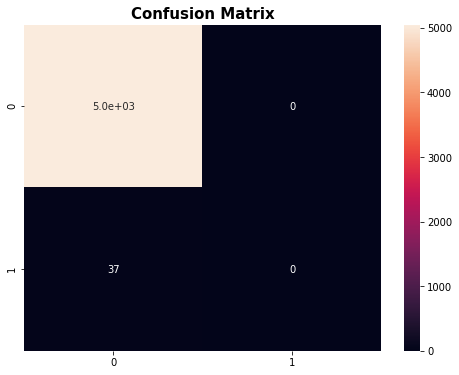

In [73]:
print('Classification Report on Training Set:')
print()
classification_summary(preds_train,y_train_max)

In [74]:
preds = model_nn.predict(X_test_nn)

In [75]:
preds.shape

(570, 2)

In [76]:
preds = np.argmax(preds, axis=1)
preds.shape

(570,)

In [77]:
y_test_max = np.argmax(y_test_nn, axis =1)
y_test_max.shape

(570,)

Classification Report on Test Set:

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       565
           1       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570



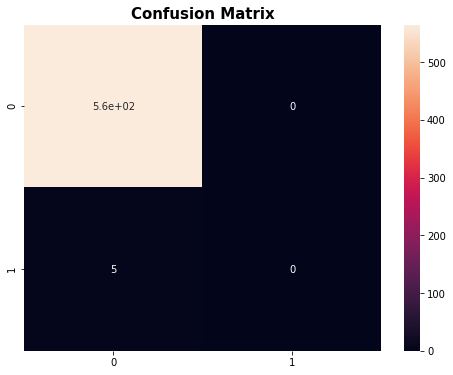

In [78]:
print('Classification Report on Test Set:')
print()
classification_summary(preds,y_test_max)

### Let's now train the same network but with data processing

In [79]:
# Data Processing Steps: SMOTE, FFT, Noise Reduction, Normalization, Standardization
train_fft_nn, test_fft_nn = apply_fft(X_resampled,X_test)
train_sav_nn, test_sav_nn = apply_filter(train_fft_nn,test_fft_nn,21,4)
train_norm_nn, test_norm_nn = apply_norm(train_sav_nn,test_sav_nn)
train_scaled_nn, test_scaled_nn = apply_stand(train_norm_nn,test_norm_nn)

In [80]:
print(train_scaled_nn.shape)
print(test_scaled_nn.shape)

(10100, 3197)
(570, 3197)


In [81]:
train_scaled_nn = np.expand_dims(train_scaled_nn, axis=2)
test_scaled_nn = np.expand_dims(test_scaled_nn, axis=2)

In [82]:
print(train_scaled_nn.shape)
print(test_scaled_nn.shape)

(10100, 3197, 1)
(570, 3197, 1)


In [83]:
y_train_nn = np.zeros((y_resampled.shape[0], 2))
y_train_nn[np.arange(y_resampled.size), y_resampled-1] = 1
y_train_nn.shape

(10100, 2)

In [84]:
model_nn_final = create_nn(train_scaled_nn)
start_time_train = timeit.default_timer()
training_history = model_nn_final.fit(train_scaled_nn, y_train_nn, validation_split = VAL_SPLIT, 
                            epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True)
time_elapsed = timeit.default_timer() - start_time_train
print('Training time: ' + str(time_elapsed))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 3197, 32)          128       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1598, 32)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1598, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 51136)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                3272768   
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                

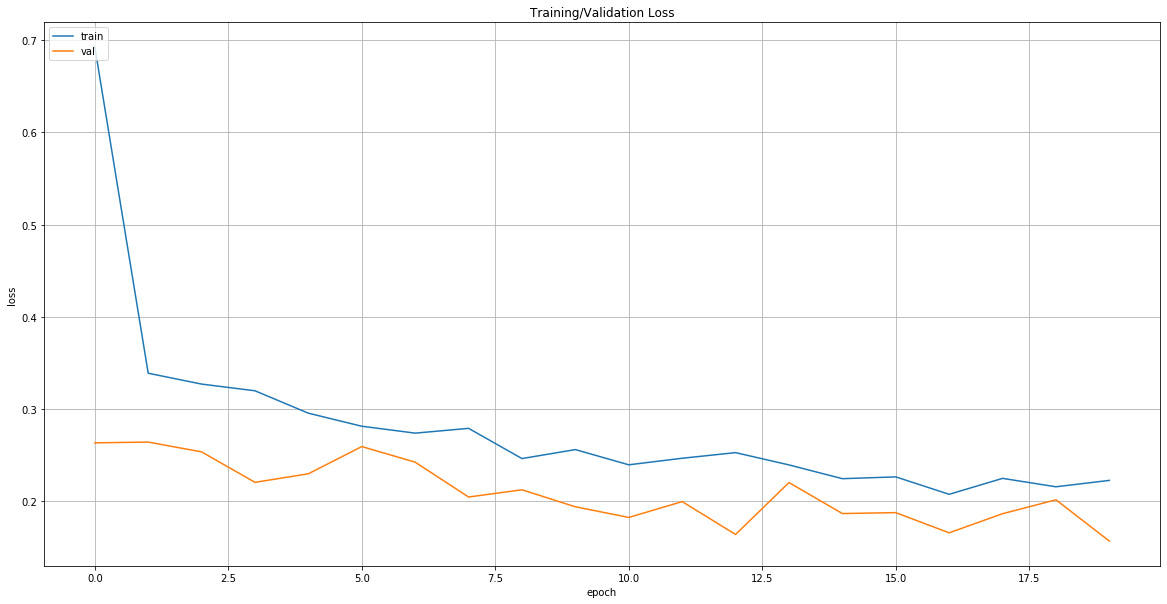

In [85]:
plt.figure(figsize = (20,10))
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('Training/Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()

In [86]:
preds_train_final = model_nn_final.predict(train_scaled_nn)
print(preds_train_final.shape)
preds_train_final = np.argmax(preds_train_final, axis=1)
print(preds_train_final.shape)

(10100, 2)
(10100,)


In [87]:
y_train_max = np.argmax(y_train_nn, axis = 1)
y_train_max.shape

(10100,)

Classification Report on Training Set:

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      5050
           1       0.98      1.00      0.99      5050

    accuracy                           0.99     10100
   macro avg       0.99      0.99      0.99     10100
weighted avg       0.99      0.99      0.99     10100



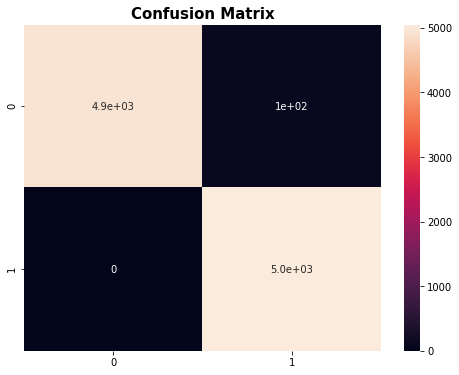

In [88]:
print('Classification Report on Training Set:')
print()
classification_summary(preds_train_final,y_train_max)

In [89]:
preds_final = model_nn_final.predict(test_scaled_nn)
print(preds_final.shape)
preds_final = np.argmax(preds_final, axis=1)
print(preds_final.shape)

(570, 2)
(570,)


In [90]:
y_test_max = np.argmax(y_test_nn, axis=1)
y_test_max.shape

(570,)

Classification Report on Test Set:

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       565
           1       0.23      0.60      0.33         5

    accuracy                           0.98       570
   macro avg       0.61      0.79      0.66       570
weighted avg       0.99      0.98      0.98       570



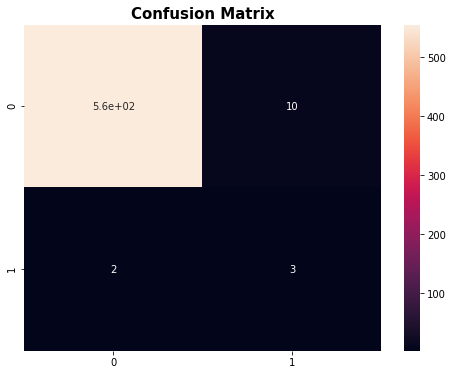

In [91]:
print('Classification Report on Test Set:')
print()
classification_summary(preds_final,y_test_max)

# Conclusion

### The best result was achieved using Decision Tree Classifier with Signal Processing which produced perfect classification with zero FPs and zero FNs (i.e. 100% Precision and 100% Recall) 

Classification Report on Training Set:

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      5050
           2       1.00      1.00      1.00        37

    accuracy                           1.00      5087
   macro avg       1.00      1.00      1.00      5087
weighted avg       1.00      1.00      1.00      5087



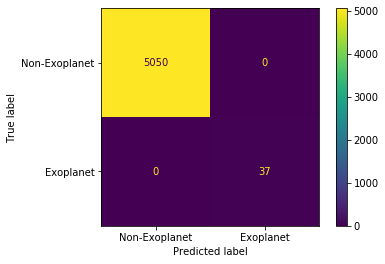

In [93]:
dt = DecisionTreeClassifier(random_state=4)
dt.fit(train_scaled, y_train)
preds_train = dt.predict(train_scaled)
print('Classification Report on Training Set:')
print()
print(classification_report(y_train,preds_train))
plot_confusion_matrix(dt, train_scaled, y_train, display_labels=['Non-Exoplanet','Exoplanet'])  
plt.show()

Classification Report on Test Set:

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       565
           2       1.00      1.00      1.00         5

    accuracy                           1.00       570
   macro avg       1.00      1.00      1.00       570
weighted avg       1.00      1.00      1.00       570



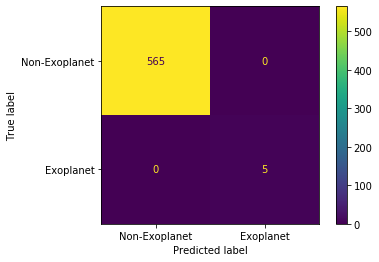

In [94]:
preds = dt.predict(test_scaled)
print('Classification Report on Test Set:')
print()
print(classification_report(y_test,preds))
plot_confusion_matrix(dt, test_scaled, y_test, display_labels=['Non-Exoplanet','Exoplanet'])  
plt.show()